## Linear Regression Part6: Over/Under fitting and Non-Linear Feature Variables

This will be the last post in the series on Linear Regression. We may revisit it in other contexts but it has served its purpose in establishing many fundamental idea of Machine Learning. There are a couple more fundamentals that are well illustrated with linear regression. Namely
- Using Non-Linear feature variables (polynomial regression for example)
- Over and Under fitting a model on the training data.
We'll look at these ideas and problems in this post to finish the series and then move on to looking at Logistic Regression. (Even though the word "regression is used there it's actually a classification algorithm ... that's just the name used for it.")

For background information the past 5 post in this series are listed below.

- [Linear Regression Part1: Introduction](https://www.pugetsystems.com/labs/hpc/Machine-Learning-and-Data-Science-Linear-Regression-Part-1-954/)
- [Linear Regression Part2: Getting and Evaluating Data](https://www.pugetsystems.com/labs/hpc/Machine-Learning-and-Data-Science-Linear-Regression-Part-2-963/)
- [Linear Regression Part3: Model and Cost Function](https://www.pugetsystems.com/labs/hpc/Machine-Learning-and-Data-Science-Linear-Regression-Part-3-965/)
- [Linear Regression Part 4: Parameter Optimization by Gradient Descent](https://www.pugetsystems.com/labs/hpc/Machine-Learning-and-Data-Science-Linear-Regression-Part-4-968/)
- [Linear Regression Part 5: Vectorization and Matrix Equations](https://www.pugetsystems.com/labs/hpc/Machine-Learning-and-Data-Science-Linear-Regression-Part-5-974/)

These posts along with the current one were converted to html from Jupyter notebooks. The notebooks are available at [https://github.com/dbkinghorn/blog-jupyter-notebooks](https://github.com/dbkinghorn/blog-jupyter-notebooks)

## Non-Linear Feature Variables
Up until now we have looked mostly at fitting our data to a straight line with a model function $h(x) a_0 + a_1x$. In the last post we showed how the regression problem could be trivially extended to multi-features with the vectorized form of the equations. That gave us models like $h(x) = a_0 + a_1x_1 + a_2x_2 \dots$ Those models would be planer or hyper-planer. Those models are great when the features in a data set closely follow lines. What if they don't do that? What if the data you are looking at is curved?  You can use non-linear feature variable terms in your model function! This is true for both the single feature variable or multi-variate cases.
>**The "Linear" in Linear Regression is referring to the model parameters, $a$ The feature varaibles can be most anything that makes sense for the data you are trying to fit your model to.**    

You can use terms like $x^2$, $\sqrt{x}$, $\exp{(-x^2)}$, $(1 - \exp{(-x)})^2$, ... as long as the parameters $a$ are just simple scaler multipliers you can use linear regression.

> **Side Note:** *Non-Linear Regression* is also very useful and you can use "least-squares" as a cost function but the problem is then non-linear optimization and there are extra difficulties to consider. I'll probably do a non-linear regression post sometime in the future. A good example of that would be fitting multi-core CPU parallel performance of some software package to Amdahl's Law. In the notation we have been using in these posts it would look like $h_a(x) = 1/( (1-a) + a/x)$ where $a$ is the "parallel fraction" and $x$ is the number of CPU cores. $h_a(x)$ is then the "speedup". Here are a couple of posts using that, [LAMMPS Optimized for Intel on Quad Socket Xeon](https://www.pugetsystems.com/labs/hpc/LAMMPS-Optimized-for-Intel-on-Quad-Socket-Xeon-593/), and [Xeon E5v3 All Core Turbo and Amdahl's Law](https://www.pugetsystems.com/labs/hpc/Xeon-E5v3-All-Core-Turbo-and-Amdahl-s-Law-759/).

### Goodness of Fit $R^2$
One of the things we are trying to achieve with non-linear feature variables is getting a better fit to our data. What does "better fit" mean, how can you measure that? If you have simple data and a simple model you may be able to make a plot and just look at how well your model is fitting the data. If you have many variables, and a complicated model visualization may be difficult. We want a number that tells us if we have made an improvement in out model. An obvious number to use would be the value of the **cost function**. It is made up of the sum of squared errors between the training data and the values predicted by the model. The linear-regression procedure gives parameters for the model that minimize that. If a non-linear feature variable is used to improve the model then the value of the cost function using the optimized parameters should decrease i.e. less error. That is a reasonable number to look at.

There is a common value that is often used to evaluate the "goodness of fit" for a regression, $R^2$. This is called various things like, coefficient of (determination, correlation, variation) etc. It's most common for people to just say "R squared".

$R^2$ uses the sum of squared errors like the cost function together with a term that is proportional to the variance of the training data.  Below is a list of the equations we derived in the [last post](https://www.pugetsystems.com/labs/hpc/Machine-Learning-and-Data-Science-Linear-Regression-Part-5-974/) together with an expression for $R^2$ so you can see how everything relates. We will use some of these equations in the Python code for the examples.  

$$ \bbox[25px,border:2px solid green]{
\begin{align}
h_a(X) & = Xa \\ \\
J(a) & = \frac{1}{2m} (Xa - y)'(Xa - y) \\ \\
\nabla_aJ(a) & =  \frac{1}{m} (X'Xa - X'y) \\ \\
a & = (X'X)^{-1}X'y \\ \\
R^2 & = 1 - \frac{(Xa - y)'(Xa - y)}{(y - \overline{y})'(y - \overline{y})}
\end{align} }$$
$\overline{y}$ is the mean of the $y$ values. Values of $R^2$ close to 1 indicate a better fit of the model to the training data.

### Example of fitting a non-linear curve using linear-regression
Let's do an example of linear regression with a non-linear feature variable model. This is data that I made up for an example but it's is typical of data you may see from some kinds of experiments or other measurements. It starts off with a steep decline and then levels off to a constant value.

It's time to write some code and make some plots so we'll load our usual Python modules into the notebook and write a few function definitions.


In [1]:
import pandas as pd  # data handeling
import numpy as np   # numeriacal computing
import matplotlib.pyplot as plt  # plotting core
import seaborn as sns  # higher level plotting tools
%matplotlib inline
sns.set()

In [2]:
def h(X,a) : # model h(X) = Xa
    h = np.dot(X,a)
    return h

def a_opt(X,y) : # linear regression solution a = (X'X)^-1 X'y = pinv(X)y
    a_opt = np.dot( np.linalg.pinv(X), y)
    return a_opt

def J(a,X,y) : # Cost function 
    m = y.size
    J = 1/(2*m) * np.dot( ( h(X,a) - y ).T, ( h(X,a) - y ) )
    return J

def R2(a,X,y) : # R squared
    y_mean = y.mean()
    R2 = 1 - ( np.dot( ( h(X,a) - y ).T, ( h(X,a) - y ) ) / np.dot( ( y - y_mean ).T, ( y - y_mean ) ) ) 
    return R2

Here's the example data and a plot, 

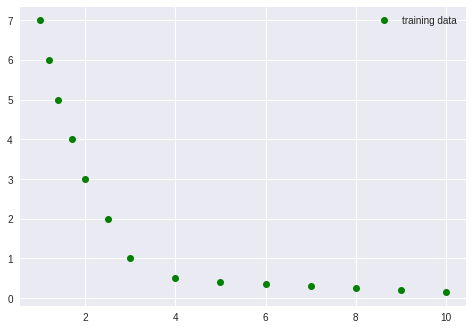

In [3]:
x = np.array([1, 1.2, 1.4, 1.7, 2, 2.5, 3, 4, 5, 6, 7, 8, 9, 10])
y = np.array([7, 6 , 5, 4, 3, 2, 1, .5, .4, .35, .3, .25 ,.2,.15])

plt.plot( x,y, "o", color='g', label='training data'); plt.legend();

To start lets just try fitting a straight line $h(x) = a_0 + a_1x$. We'll construct the augmented matrix $X$, solve the regression equation to find the best values of $a$, then plot the result and look at the value of $J$ and $R^2$

### $h(x) = a_0 + a_1x$

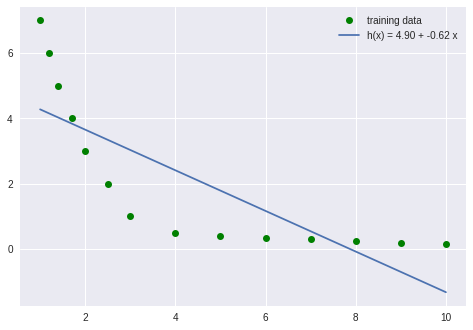

In [4]:
X = np.column_stack( (np.ones((x.size,1)) , x )) # construct the augmented matrix X
a = a_opt(X,y)   # solve the regression 

fig, ax = plt.subplots()
ax.plot( x,y, "o", color='g', label='training data')  # plot the test data

xt = np.linspace(1,10,100)
ax.plot(xt, a[0] + a[1]*xt  ,  label='h(x) = %.2f + %.2f x' %(a[0], a[1]))  # plot the model function
ax.legend()


In [5]:
print('a =', a)  # print the values of a
print('J =', J(a,X,y)) # value of Cost function
print("R2 =", R2(a,X,y)) # R squared 

a = [ 4.89940618 -0.62203376]
J = 0.984045624718
R2 = 0.636583343055


That's not so good! No surprise! Next lets try changing $x$ to $x^2$ thinking that a simple parabola may be a better fit.
**Note, since we are using numpy arrays it is easy to change our model by changing how the augmented matrix $X$ is constructed.**

### $h(x) = a_0 + a_1x^2$

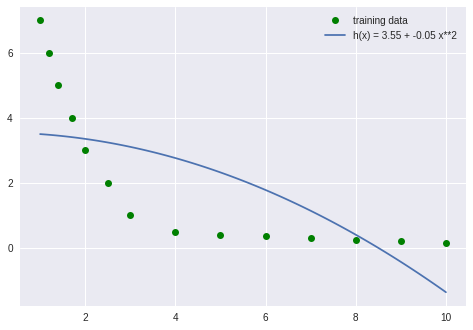

In [6]:
X = np.column_stack( (np.ones((x.size,1)) , x**2 )) # construct the augmented matrix X
a = a_opt(X,y)   # solve the regression 

fig, ax = plt.subplots()
ax.plot( x,y, "o", color='g', label='training data')  # plot the test data

xt = np.linspace(1,10,100)
ax.plot(xt, a[0] + a[1]*xt**2  ,  label='h(x) = %.2f + %.2f x**2' %(a[0], a[1]))  # plot the model function
ax.legend()

In [7]:
print('a =', a)  # print the values of a
print('J =', J(a,X,y)) # value of Cost function
print("R2 =", R2(a,X,y)) # R squared 

a = [ 3.54966214 -0.04916554]
J = 1.49068464586
R2 = 0.449477120827


That's worse! It looks like the regression found a minimum for $a$ that has the curve opposite of what I expected.

So, lets try something different. This time I'll keep $x$ and add an additional feature $x^2$.  

### $h(x) = a_0 + a_1x + a_2x^2$

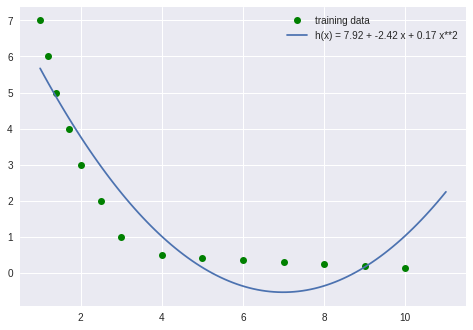

In [8]:
X = np.column_stack( (np.ones((x.size,1)) , x, x**2 )) # construct the augmented matrix X
a = a_opt(X,y)   # solve the regression 

fig, ax = plt.subplots()
ax.plot( x,y, "o", color='g', label='training data')  # plot the test data

xt = np.linspace(1,11,100)
ax.plot(xt, a[0] + a[1]*xt + a[2]*xt**2  ,  label='h(x) = %.2f + %.2f x + %.2f x**2' %(a[0], a[1], a[2]))  # plot the model function
ax.legend()

In [9]:
print('a =', a)  # print the values of a
print('J =', J(a,X,y)) # value of Cost function
print("R2 =", R2(a,X,y)) # R squared 

a = [ 7.91654996 -2.41851151  0.17301985]
J = 0.288881131548
R2 = 0.893313671191


That is a better fit. The cost, $J$ has gone down and $R^2$ is closer to 1, However, he model is not behaving the way we want (it's rising at the end of the data).

Lets try a different model. $1/x$ would descend rapidly and then tapper off toward 0.

### $h(x) = a_0 + a_1 1/x$

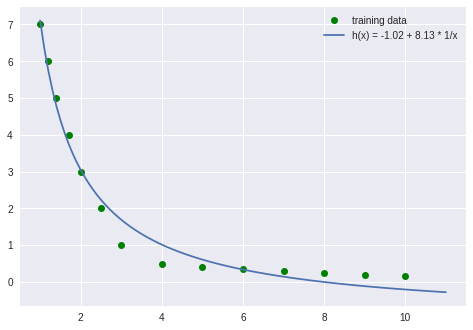

In [10]:
X = np.column_stack( (np.ones((x.size,1)) , 1/x )) # construct the augmented matrix X
a = a_opt(X,y)   # solve the regression 

fig, ax = plt.subplots()
ax.plot( x,y, "o", color='g', label='training data')  # plot the test data

xt = np.linspace(1,11,100)
ax.plot(xt, a[0] + a[1]/xt  ,  label='h(x) = %.2f + %.2f * 1/x' %(a[0], a[1]))  # plot the model function
ax.legend()

In [11]:
print('a =', a)  # print the values of a
print('J =', J(a,X,y)) # value of Cost function
print("R2 =", R2(a,X,y)) # R squared 

a = [-1.01949439  8.12888628]
J = 0.0474441002675
R2 = 0.982478478764


That is a significant improvement and now $R^2$ is getting closer to 1. It's still not converging to a constant value so lets try one more model function.

### $h(x) = a_0 + a_1\exp(-x)$

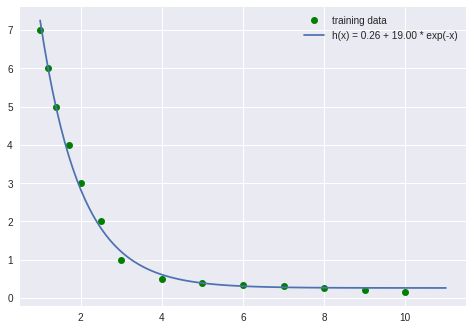

In [12]:
X = np.column_stack( (np.ones((x.size,1)) , np.exp(-x) )) # construct the augmented matrix X
a = a_opt(X,y)   # solve the regression 

fig, ax = plt.subplots()
ax.plot( x,y, "o", color='g', label='training data')  # plot the test data

xt = np.linspace(1,11,100)
ax.plot(xt, a[0] + a[1]*np.exp(-xt)  ,  label='h(x) = %.2f + %.2f * exp(-x)' %(a[0], a[1]))  # plot the model function
ax.legend()

In [13]:
print('a =', a)  # print the values of a
print('J =', J(a,X,y)) # value of Cost function
print("R2 =", R2(a,X,y)) # R squared 

a = [  0.26095836  19.00064051]
J = 0.00971408120393
R2 = 0.996412504839


That is a very good fit and the model has the behavior that we want. The $R^2$ is also very close to 1 indication that the fit to the training data is very good and the cost, $J$ is near 0.

### Key points to note;
- Linear regression can be easily extended to fit non-linear data by adding non-linear feature variables as long as the model optimization parameters, $a$ are kept linear.
- Python with numpy is simple to use for experimenting with data and different model functions.
- Your intuition about a candidate for a model function may not be correct!
- Having a measure like $R^2$ for the "goodness of fit" is important. It will become very important when we look at over-fitting in the next section.

Another point in addition to the above is that if your data has very complex behavior it may be difficult to come up with a suitable model. One solution to this problem is to try a very general model with lots of terms. The regression may be able to pick out the terms that are useful to reduce the error by making the parameters of important terms large and unimportant terms small. There is a very serious problem that can occur if you use a complex model with many terms -- over-fitting!


## Over and Under Fitting
Under-fitting is usually fairly obvious.If your model is inadequate to represent the data you are trying to fit you can usually see that visually in a plot or just observe that the value of the cost function, $J$, is high or $R^2$ is far from 1. Looking at how well or poorly your model predicts a result from a few data points in your training set will tell you right away if your model is inadequate. [It's better to have a separate test set but we will get to that later.]

Over-fitting can be more subtle. You may have a model that fits your training data very well, maybe even perfectly, and still have a model that does a terrible job of predicting unknown values.
> **The goal of fitting model parameters to a training set is to produce a model that "generalizes" well for making predictions from data that is NOT in your training set. Over-fitting your model to your training set can produce a model that has very little predictive value.**

Over-fitting is serious problem in machine learning and we will discuss it in more detail and look at ways to avoid it in later posts. Right now I just want to introduce the problem in a way that is very clear and easy to visualize.  To do this I will generate some training data from a known function and then show what can happen by over-fitting that data with a polynomial model function.

This will be illustrated with a series of regression fits to 6 points of training-set data that is selected from a known function, $x\sin(x/2)$. There will also be 6 points of data for a test-set that is taken from other places along the curve. The training and test sets also include a small amount of random "noise". We will calculate the cost function, $J$, and $R^2$ values to evaluate the goodness of fit. This goodness of fit will be checked against the training-set and the test-set.

There will be some good lessons to learn from this!


In [14]:
def f(x) :  # sourse of the data 
    f = x*np.sin(x/2)
    return f

np.random.seed(22)
noise = np.random.randn(12)  # some random "normal" noise

x = np.linspace(0,10,6) # x for training-set
y = f(x) + noise[0:6]   # y for training-set  

xtest = np.linspace(-1,9,6)     # x for test-set
ytest = f(xtest) + noise[6:12]  # y for test-set

Here is a plot of all the data,

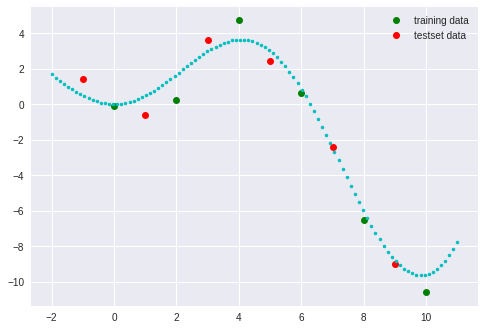

In [15]:
fig, ax = plt.subplots()

ax.plot(x,y, 'o', color='g', label='training data' )
ax.plot(xtest,ytest, 'o', color='r',label='testset data')

xt = np.linspace(-2,11,100)
ax.plot(xt, f(xt), '.', color='c')
plt.legend()

Now we will start generating models with increasing powers of $x$ and looking at the goodness of fit.

### $h(x) = a_0 + a_1x$

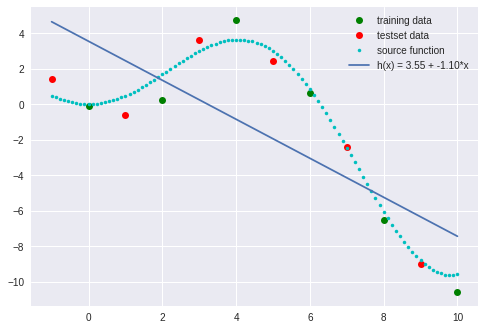

In [16]:
X = np.column_stack( (np.ones((x.size,1)) , x )) # construct the augmented matrix X
Xtest = np.column_stack( (np.ones((x.size,1)) , xtest )) # needed for error analysis
a = a_opt(X,y)   # solve the regression 

fig, ax = plt.subplots()
ax.plot( x,y, "o", color='g', label='training data')  # plot the test data
ax.plot(xtest,ytest, 'o', color='r', label='testset data')

xt = np.linspace(-1,10,100)
ax.plot(xt, f(xt), '.', color='c', label='source function')
ax.plot(xt, a[0] + a[1]*xt ,  
        label='h(x) = %.2f + %.2f*x' 
        %(a[0],a[1]))  # plot the model function
ax.legend()

In [17]:
print('a =', a)  # print the values of a
print('training-set: ','J =', J(a,X,y), "   R2 =", R2(a,X,y))

print('test-set:     ','J =', J(a,Xtest,ytest), "   R2 =", R2(a,Xtest,ytest))


a = [ 3.54602792 -1.09864046]
training-set:  J = 5.87325826227    R2 = 0.545207695905
test-set:      J = 5.05501226338    R2 = 0.423267235186


The fit is not very good as expected, but, note that $J$ and $R^2$ for training and test sets are similar.

Now add an $x^2$ term, do the regression and look at the results,

### $h(x) = a_0 + a_1x +a_2x^2$

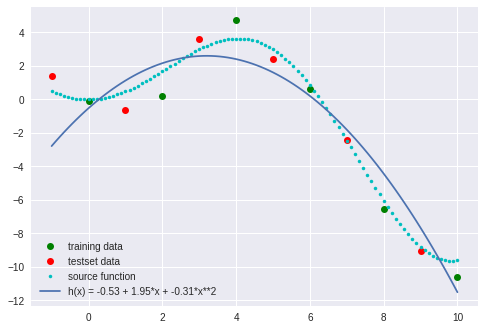

In [18]:
X = np.column_stack( (np.ones((x.size,1)) , x, x**2 )) # construct the augmented matrix X
Xtest = np.column_stack( (np.ones((x.size,1)) , xtest, xtest**2 )) # needed for error analysis
a = a_opt(X,y)   # solve the regression 

fig, ax = plt.subplots()
ax.plot( x,y, "o", color='g', label='training data')  # plot the test data
ax.plot(xtest,ytest, 'o', color='r', label='testset data')

xt = np.linspace(-1,10,100)
ax.plot(xt, f(xt), '.', color='c', label='source function')
ax.plot(xt, a[0] + a[1]*xt + a[2]*xt**2 ,  
        label='h(x) = %.2f + %.2f*x + %.2f*x**2' 
        %(a[0],a[1],a[2]))  # plot the model function
ax.legend()

In [19]:
print('a =', a)  # print the values of a
print('training-set: ','J =', J(a,X,y), "   R2 =", R2(a,X,y))

print('test-set:     ','J =', J(a,Xtest,ytest), "   R2 =", R2(a,Xtest,ytest))

a = [-0.52521439  1.95479127 -0.30534317]
training-set:  J = 1.23225437608    R2 = 0.904581106108
test-set:      J = 2.04410736779    R2 = 0.766785196083


The value of $J$ has come down and $R^2$ is better for the training and test set.

Now add an $x^3$ term,

### $h(x) = a_0 + a_1x +a_2x^2 +a_3x^3$

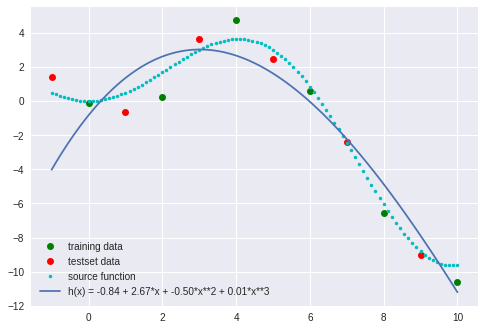

In [20]:
X = np.column_stack( (np.ones((x.size,1)) , x, x**2, x**3 )) # construct the augmented matrix X
Xtest = np.column_stack( (np.ones((x.size,1)) , xtest, xtest**2, xtest**3 )) # needed for error analysis
a = a_opt(X,y)   # solve the regression 

fig, ax = plt.subplots()
ax.plot( x,y, "o", color='g', label='training data')  # plot the test data
ax.plot(xtest,ytest, 'o', color='r', label='testset data')

xt = np.linspace(-1,10,100)
ax.plot(xt, f(xt), '.', color='c', label='source function')
ax.plot(xt, a[0] + a[1]*xt + a[2]*xt**2 + a[3]*xt**3,  
        label='h(x) = %.2f + %.2f*x + %.2f*x**2 + %.2f*x**3' 
        %(a[0],a[1],a[2],a[3]))  # plot the model function
ax.legend()

In [21]:
print('a =', a)  # print the values of a
print('training-set: ','J =', J(a,X,y), "   R2 =", R2(a,X,y))

print('test-set:     ','J =', J(a,Xtest,ytest), "   R2 =", R2(a,Xtest,ytest))

a = [-0.83922841  2.67178995 -0.50160194  0.01308392]
training-set:  J = 1.17309149293    R2 = 0.909162349217
test-set:      J = 2.97262107162    R2 = 0.660849889169


Notice that $R^2$ is improving for the training-set but getting worse for the test-set.

Now add $x^4$,

### $h(x) = a_0 + a_1x +a_2x^2 +a_3x^3 +a_4x^4$


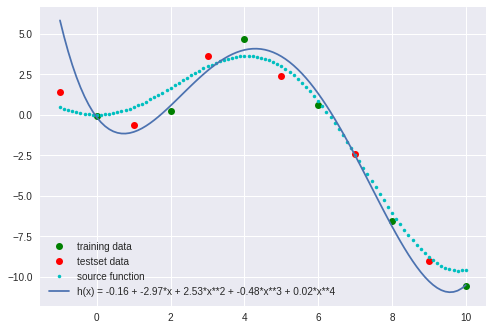

In [22]:
X = np.column_stack( (np.ones((x.size,1)) , x, x**2, x**3, x**4 )) # construct the augmented matrix X
Xtest = np.column_stack( (np.ones((x.size,1)) , xtest, xtest**2, xtest**3, xtest**4 )) # needed for error analysis
a = a_opt(X,y)   # solve the regression 

fig, ax = plt.subplots()
ax.plot( x,y, "o", color='g', label='training data')  # plot the test data
ax.plot(xtest,ytest, 'o', color='r', label='testset data')

xt = np.linspace(-1,10,100)
ax.plot(xt, f(xt), '.', color='c', label='source function')
ax.plot(xt, a[0] + a[1]*xt + a[2]*xt**2 + a[3]*xt**3 + a[4]*xt**4,  
        label='h(x) = %.2f + %.2f*x + %.2f*x**2 + %.2f*x**3 + %.2f*x**4' 
        %(a[0],a[1],a[2],a[3],a[4]))  # plot the model function
ax.legend()

In [23]:
print('a =', a)  # print the values of a
print('training-set: ','J =', J(a,X,y), "   R2 =", R2(a,X,y))

print('test-set:     ','J =', J(a,Xtest,ytest), "    R2 =", R2(a,Xtest,ytest))

a = [-0.16254408 -2.96724612  2.52937995 -0.48033174  0.02467078]
training-set:  J = 0.1046542381    R2 = 0.991896160538
test-set:      J = 1.97358514007     R2 = 0.774831166549


Notice now that the training-set fit is looking very good but the test-set is not a good fit.

Add $x^5$,

### $h(x) = a_0 + a_1x +a_2x^2 +a_3x^3 +a_4x^4 +a_5x^5$

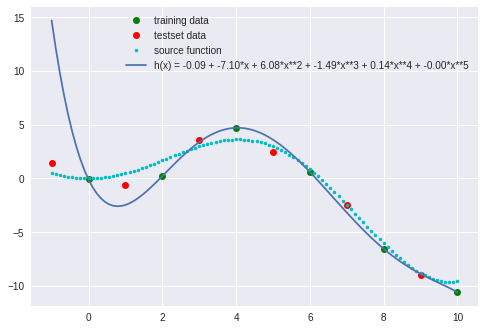

In [24]:
X = np.column_stack( (np.ones((x.size,1)) , x, x**2, x**3, x**4, x**5 )) # construct the augmented matrix X
Xtest = np.column_stack( (np.ones((x.size,1)) , xtest, xtest**2, xtest**3, xtest**4, xtest**5 )) # needed for error analysis
a = a_opt(X,y)   # solve the regression 

fig, ax = plt.subplots()
ax.plot( x,y, "o", color='g', label='training data')  # plot the test data
ax.plot(xtest,ytest, 'o', color='r', label='testset data')

xt = np.linspace(-1,10,100)
ax.plot(xt, f(xt), '.', color='c', label='source function')
ax.plot(xt, a[0] + a[1]*xt + a[2]*xt**2 + a[3]*xt**3 + a[4]*xt**4 + a[5]*xt**5,  
        label='h(x) = %.2f + %.2f*x + %.2f*x**2 + %.2f*x**3 + %.2f*x**4 + %.2f*x**5' 
        %(a[0],a[1],a[2],a[3],a[4],a[5]))  # plot the model function
ax.legend()

In [25]:
print('a =', a)  # print the values of a
print('training-set: ','J =', J(a,X,y), "   R2 =", R2(a,X,y))

print('test-set:     ','J =', J(a,Xtest,ytest), "       R2 =", R2(a,Xtest,ytest))

a = [ -9.19499198e-02  -7.09935750e+00   6.08114853e+00  -1.48923991e+00
   1.40489323e-01  -4.63274162e-03]
training-set:  J = 3.85913318695e-22    R2 = 1.0
test-set:      J = 15.2463480026        R2 = -0.739475193872


Now the training-set fit is exact! The cost function $J$ is 0 and $R^2$ is 1. The test-set still has a poor fit. Even though the model function fits the training-set perfectly it is not a very good model overall. It's not as bad as it could be!

Lets add 3 more terms just for fun,

### $h(x) = a_0 + a_1x +a_2x^2 +a_3x^3 +a_4x^4 +a_5x^5 +a_6x^6 +a_7x^7 +a_8x^8$

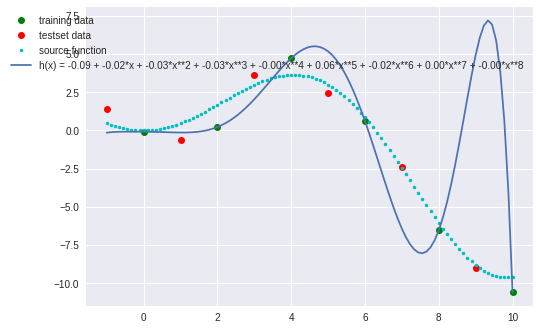

In [26]:
X = np.column_stack( (np.ones((x.size,1)) , x, x**2, x**3, x**4, x**5, x**6, x**7, x**8 )) # construct the augmented matrix X
Xtest = np.column_stack( (np.ones((x.size,1)) , xtest, xtest**2, xtest**3, xtest**4, xtest**5, xtest**6, xtest**7, xtest**8 )) # needed for error analysis
a = a_opt(X,y)   # solve the regression 

fig, ax = plt.subplots()
ax.plot( x,y, "o", color='g', label='training data')  # plot the test data
ax.plot(xtest,ytest, 'o', color='r', label='testset data')

xt = np.linspace(-1,10,100)
ax.plot(xt, f(xt), '.', color='c', label='source function')
ax.plot(xt, a[0] + a[1]*xt + a[2]*xt**2 + a[3]*xt**3 + a[4]*xt**4 + a[5]*xt**5 + a[6]*xt**6 + a[7]*xt**7 + a[8]*xt**8,  
        label='h(x) = %.2f + %.2f*x + %.2f*x**2 + %.2f*x**3 + %.2f*x**4 + %.2f*x**5 + %.2f*x**6 + %.2f*x**7 + %.2f*x**8' 
        %(a[0],a[1],a[2],a[3],a[4],a[5],a[6],a[7],a[8]))  # plot the model function
ax.legend()

In [27]:
print('a =', a)  # print the values of a
print('training-set: ','J =', J(a,X,y), "   R2 =", R2(a,X,y))

print('test-set:     ','J =', J(a,Xtest,ytest), "       R2 =", R2(a,Xtest,ytest))

a = [-0.09194992 -0.02050446 -0.03094535 -0.03335898 -0.00405174  0.05735354
 -0.02065887  0.00250499 -0.0001006 ]
training-set:  J = 3.55685934581e-22    R2 = 1.0
test-set:      J = 18.6227485609        R2 = -1.1246930188


Garbage!

### Key points to note;
- Just because you have a good fit to a training-set doesn't mean you have a good model!
- You need to have some kind of numerical measure of goodness of fit.
- You need to pull a test-set out of your data-set to use to evaluate the "generalization" of your model.
- The larger and more complex the model to more risk there is of over fitting.
- Things can and do go wrong!

We have covered a lot of ground and presented many fundamental ideas and problems in Machine Learning in this series of posts. I hope you've enjoyed these posts as much as I have enjoyed writing them! I'll start in on other Machine Learning topics in the next posts.

**Happy computing! --dbk**  